# NetCDF Demo

In this demo we load one `dispersion.nc` file and explore how to visualize the data within the file.

## Accessing the File

We use the forecast for January 1, 2024 where the weather forecast is initiated at 00:00:00 UTC and the smoke forecast is initialized at 08:00:00 UTC. You can download this file by navigating to the URL below.

In [49]:
forecast_id = "BSC00CA12-01"
yyyymmdd = "20210304"
init_time = "08"

url = (
    f"https://firesmoke.ca/forecasts/{forecast_id}/{yyyymmdd}{init_time}/dispersion.nc"
)

print(f"Navigate to this URL in your browser: {url}")

Navigate to this URL in your browser: https://firesmoke.ca/forecasts/BSC00CA12-01/2021030408/dispersion.nc


### Opening the File

We use xarray to open the NetCDF file and preview it.

In [50]:
import xarray as xr

ds = xr.open_dataset("dispersion.nc")

ds

<xarray.Dataset>
Dimensions:  (TSTEP: 51, VAR: 1, DATE-TIME: 2, LAY: 1, ROW: 381, COL: 1041)
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY, ROW, COL
Data variables:
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 ...
    PM25     (TSTEP, LAY, ROW, COL) float32 ...
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2021063
    CTIME:          101914
    WDATE:          2021063
    ...             ...
    VGLVLS:         [10.  0.]
    GDNAM:          HYSPLIT CONC    
    UPNAM:          hysplit2netCDF  
    VAR-LIST:       PM25            
    FILEDESC:       Hysplit Concentration Model Output                       ...
    HISTORY:

## Using the Data

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Accessing Arrays

The data we are interested in is the PM2.5 values. Let's use `xarray` to preview the `PM25` variable in our file.

In [53]:
ds["PM25"]

<xarray.DataArray 'PM25' (TSTEP: 51, LAY: 1, ROW: 381, COL: 1041)>
array([[[[0.000000e+00, ..., 0.000000e+00],
         ...,
         [0.000000e+00, ..., 0.000000e+00]]],


       ...,


       [[[0.000000e+00, ..., 2.804227e-11],
         ...,
         [0.000000e+00, ..., 0.000000e+00]]]], dtype=float32)
Dimensions without coordinates: TSTEP, LAY, ROW, COL
Attributes:
    long_name:  PM25            
    units:      ug/m^3          
    var_desc:   PM25                                                         ...

The dimensions of the `PM25` data array are composed of `TSTEP`, `LAY`, `ROW`, and `COL`. Using this information, let's try visualizing time step 15.

In [55]:
# use .values to get the four dimensional array.
ds_pm25_vals = ds["PM25"].values
print(f'The shape of the data contained in our files is: {np.shape(ds_pm25_vals)}')

# let's use np.squeeze to drop the LAY axis
ds_pm25_vals = np.squeeze(ds_pm25_vals)
print(f'After squeezing, the shape is: {np.shape(ds_pm25_vals)}')

The shape of the data contained in our files is: (51, 1, 381, 1041)
After squeezing, the shape is: (51, 381, 1041)


### Visualize Array in `matplotlib`

Now that we squeezed away the `LAY` dimension, we can index time step 15 and use matplotlib to visualize the timestep

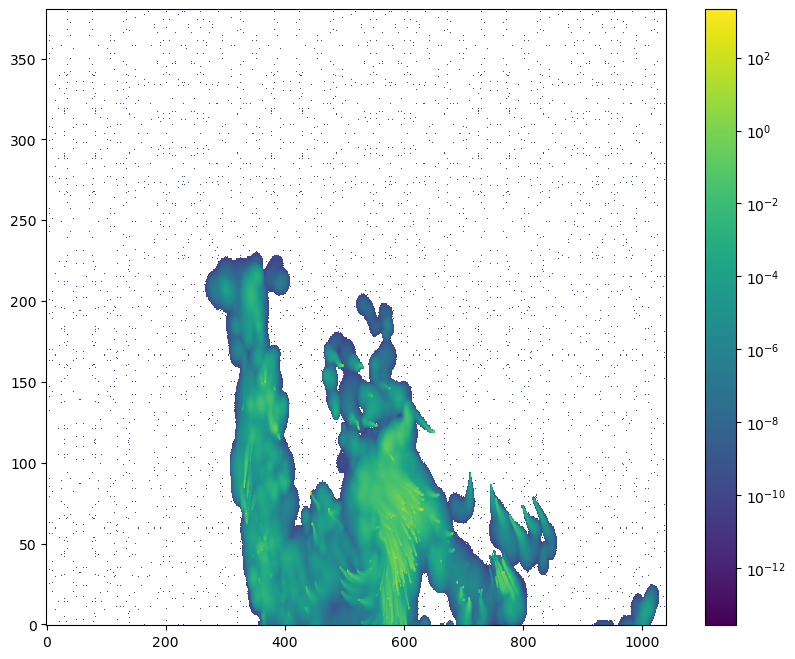

In [94]:
tstep = 15
smoke_at_tstep = ds_pm25_vals[tstep, :, :]
fig,axes=plt.subplots(1,1,figsize=(10,8))
axp = axes.imshow(data, aspect='auto',origin='lower',cmap='viridis', norm="log")
plt.colorbar(axp,location='right')
plt.show()

Notice there are no axis labels or metadata presented here. Next we will show how to place this data into the context of metadata, so the data is actually interpretable.

## Incorporating Metadata to Visualization via Coordinates

#### Latitude and Longitude Coordinates

`dispersion.nc` includes attributes to generate the latitude and longitude values on the grid defined by `NCOLS` and `NROWS`. We use this grid to match each data point in the `PM25` variable to a lat/lon coordinate.

In [62]:
xorig = ds.XORIG
yorig = ds.YORIG
xcell = ds.XCELL
ycell = ds.YCELL
ncols = ds.NCOLS
nrows = ds.NROWS

longitude = np.linspace(xorig, xorig + xcell * (ncols - 1), ncols)
latitude = np.linspace(yorig, yorig + ycell * (nrows - 1), nrows)

print("Size of longitude & latitude arrays:")
print(f'np.size(longitude) = {np.size(longitude)}')
print(f'np.size(latitude) = {np.size(latitude)}\n')
print("Min & Max of longitude and latitude arrays:")
print(f'longitude: min = {np.min(longitude)}, max = {np.max(longitude)}')
print(f'latitude: min = {np.min(latitude)}, max = {np.max(latitude)}')

Size of longitude & latitude arrays:
np.size(longitude) = 1041
np.size(latitude) = 381

Min & Max of longitude and latitude arrays:
longitude: min = -156.0, max = -51.999998450279236
latitude: min = 32.0, max = 70.00000056624413


**TODO: DESCRIBE THIS BETTER**

`xarray` allows us to create coordinates, which maps variable values to a value of our choice. In this case, we create coordinates mapping PM25 values to a latitude and longitude value.

In [68]:
# Create coordinates for lat and lon (credit: Aashish Panta)
ds.coords['lat'] = ('ROW', latitude)
ds.coords['lon'] = ('COL', longitude)

# Replace col and row dimensions with newly calculated lon and lat arrays (credit: Aashish Panta)
ds = ds.swap_dims({'COL': 'lon', 'ROW': 'lat'})

ds

<xarray.Dataset>
Dimensions:  (TSTEP: 51, VAR: 1, DATE-TIME: 2, LAY: 1, lat: 381, lon: 1041)
Coordinates:
  * lat      (lat) float64 32.0 32.1 32.2 32.3 32.4 ... 69.6 69.7 69.8 69.9 70.0
  * lon      (lon) float64 -156.0 -155.9 -155.8 -155.7 ... -52.2 -52.1 -52.0
Dimensions without coordinates: TSTEP, VAR, DATE-TIME, LAY
Data variables:
    TFLAG    (TSTEP, VAR, DATE-TIME) int32 ...
    PM25     (TSTEP, LAY, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/33)
    IOAPI_VERSION:  $Id: @(#) ioapi library version 3.0 $                    ...
    EXEC_ID:        ????????????????                                         ...
    FTYPE:          1
    CDATE:          2021063
    CTIME:          101914
    WDATE:          2021063
    ...             ...
    VGLVLS:         [10.  0.]
    GDNAM:          HYSPLIT CONC    
    UPNAM:          hysplit2netCDF  
    VAR-LIST:       PM25            
    FILEDESC:       Hysplit Concentration Model Output                       ...
    HISTORY:

Now let's move on to incorporating time stamp metadata.

#### Time Coordinates

Recall, there is a `TFLAG` variable in `dispersion.nc`.

In [69]:
ds['TFLAG']

<xarray.DataArray 'TFLAG' (TSTEP: 51, VAR: 1, DATE-TIME: 2)>
[102 values with dtype=int32]
Dimensions without coordinates: TSTEP, VAR, DATE-TIME
Attributes:
    units:      <YYYYDDD,HHMMSS>
    long_name:  TFLAG           
    var_desc:   Timestep-valid flags:  (1) YYYYDDD or (2) HHMMSS             ...

The first `TFLAG` looks like the following:

In [77]:
ds['TFLAG'].values[0]

array([[2021063,   90000]], dtype=int32)

This time flag requires processing to be immediately legible. Let's write a function to process the time flag accordingly.

In [74]:
def parse_tflag(tflag):
    """
    Return the tflag as a datetime object
    :param list tflag: a list of two int32, the 1st representing date and 2nd representing time
    """
    # obtain year and day of year from tflag[0] (date)
    date = int(tflag[0])
    year = date // 1000 # first 4 digits of tflag[0]
    day_of_year = date % 1000 # last 3 digits of tflag[0]

    # create datetime object representing date
    final_date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year - 1)

    # obtain hour, mins, and secs from tflag[1] (time)
    time = int(tflag[1])
    hours = time // 10000 # first 2 digits of tflag[1]
    minutes = (time % 10000) // 100 # 3rd and 4th digits of tflag[1] 
    seconds = time % 100  # last 2 digits of tflag[1]

    # create final datetime object
    full_datetime = datetime.datetime(year, final_date.month, final_date.day, hours, minutes, seconds)
    return full_datetime

Now we have a datetime object to represent the timeflag in a more legible and usable format.

In [82]:
print(parse_tflag(ds['TFLAG'].values[0][0]))

2021-03-04 09:00:00


As we did above, we can set coordinates mapping each TSTEP to the corresponding legible time flag.

In [85]:
# get all tflags
tflag_values = ds['TFLAG'].values

# to store legible time flags timestamps
timestamps = []

# convert all tflags to datetime timestamps, store in timestamps list
for tflag in tflag_values:
    timestamps.append(pd.Timestamp(parse_tflag(tflag[0])))

In [86]:
# set coordinates to each timestep with these pandas timestamps
ds.coords['time'] = ('TSTEP', timestamps)

In [87]:
# Replace tstep dimension with newly calculated timestamps array
ds = ds.swap_dims({'TSTEP': 'time'})

### Visualize Array in `matplotlib`

Let's visualize timestep 15 again, but now we can label the data using latitudes and longitudes, and the corresponding time flag.

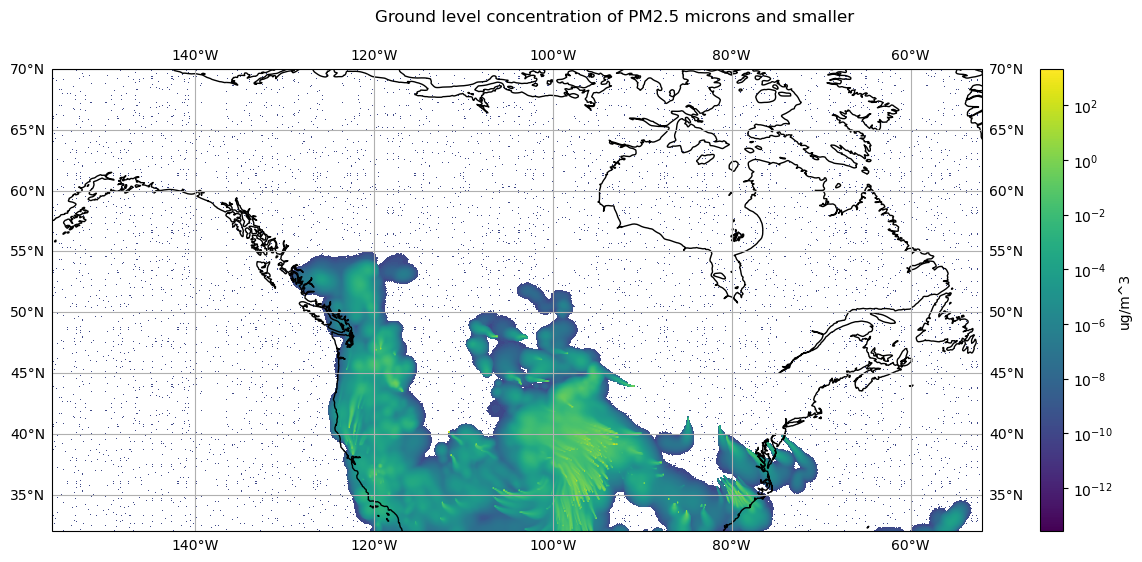

In [96]:
tstep = 15
smoke_at_tstep = ds_pm25_vals[tstep, :, :]

# Let's use matplotlib's imshow, since our data is on a grid
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

# Initialize a figure and plot, so we can customize figure and plot of data
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
# ref: https://scitools.org.uk/cartopy/docs/latest/getting_started/index.html
my_fig, my_plt = plt.subplots(figsize=(15, 6), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Let's set some parameters to get the visualization we want
# ref: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

# color PM25 values on a log scale, since values are small
my_norm = "log" 
# this will number our x and y axes based on the longitude latitude range
my_extent = [np.min(longitude), np.max(longitude), np.min(latitude), np.max(latitude)]
# ensure the aspect ratio of our plot fits all data, matplotlib can does this automatically
my_aspect = 'auto'
# tell matplotlib, our origin is the lower-left corner
my_origin = 'lower'
# select a colormap for our plot and the color bar on the right
my_cmap = 'viridis'

# create our plot using imshow
plot = my_plt.imshow(data, norm=my_norm, extent=my_extent, 
          aspect=my_aspect, origin=my_origin, cmap=my_cmap)

# draw coastlines
my_plt.coastlines()

# draw latitude longitude lines
# ref: https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/gridliner.html
my_plt.gridlines(draw_labels=True)

# add a colorbar to our figure, based on the plot we just made above
my_fig.colorbar(plot,location='right', label='ug/m^3')

# # Set x and y axis labels on our ax
# my_plt.set_xlabel('Longitude')
# my_plt.set_ylabel('Latitude')

# Set title of our figure
my_fig.suptitle('Ground level concentration of PM2.5 microns and smaller')

# # Set title of our plot as the timestamp of our data
# my_plt.set_title(f'{my_timestamp}')

# Show the resulting visualization
plt.show()